## Ансамбли и полносвязные нейронные сети
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.76$ - 0 баллов
- $0.76 < AUC \leq 0.77$ - 2 балла
- $0.77 < AUC \leq 0.78$ - 4 балла
- $0.78 < AUC \leq 0.79$ - 6 баллов
- $0.79 < AUC \leq 0.80$ - 8 баллов
- $AUC > 0.80$ - 10 баллов


In [1]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

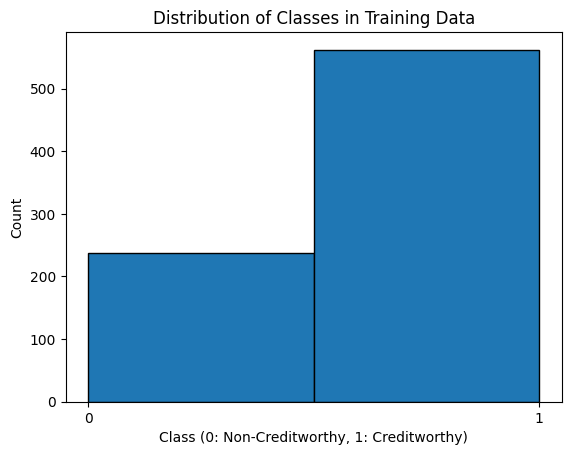

In [4]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

In [8]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(X_test)

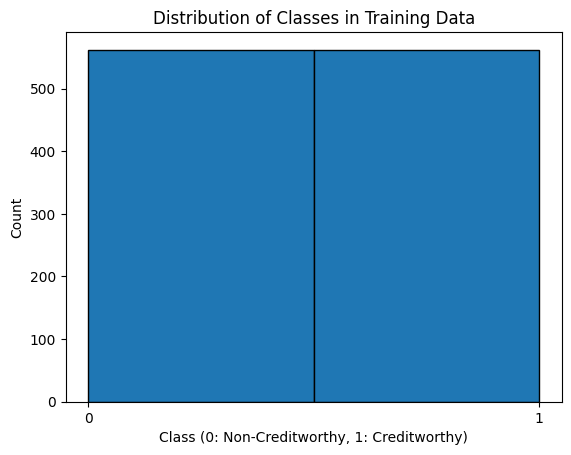

In [9]:
plt.hist(y_balanced, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

Улучшать метрики моделей будем через оптимизацию параметров, для этого для начала опредилимся со списком парметров для RandomizedSearchCV.

In [11]:
# Рассмотрим стандартные параметры для каждой модели.
params_for_RFC = {'n_estimators': randint(50, 200), 'max_depth': [None] + list(randint(1, 20).rvs(size=5)), 'min_samples_split': randint(2, 30), 'min_samples_leaf': randint(1, 10)}

params_for_GB = {'n_estimators': randint(50, 200), 'learning_rate': uniform(0.01, 0.3), 'max_depth': randint(3, 10), \
                 'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1, 4), 'subsample': uniform(0.6, 0.4), \
                    'max_features': ['sqrt', 'log2', None], 'loss': ['exponential'], 'warm_start': [True, False]}

params_for_MLP = {'alpha': [0.0001, 0.001, 0.01, 0.1], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'activation': ['relu', 'tanh', 'logistic'],\
                  'batch_size': [32, 64, 128], 'solver': ['lbfgs', 'sgd', 'adam'], 'momentum': [0.9, 0.95, 0.99], 'early_stopping': [True, False], \
                    'validation_fraction': [0.1, 0.2, 0.3]}

Объявим все модели для более простого их использования в дальнейшем.

In [12]:
RFC = RandomForestClassifier(random_state=42)
GB = GradientBoostingClassifier(random_state=42)
MLP = MLPClassifier(hidden_layer_sizes=(30,), max_iter=650, random_state=42)

Добавим игнорирование предупреждений, для того, чтобы вывод выглядел красивее.

In [26]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Перейдём к оптимизации параметров каждой модели методом RandomizedSearchCV, а также сразу выведем значение метрик для каждой модели. Для удобства будем сразу пользоваться лучшей моделью из RandomizedSearchCV, а не записывать и передовать параметры в модель.

In [27]:
random_search_for_RFC = RandomizedSearchCV(RFC, param_distributions=params_for_RFC, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
random_search_for_RFC.fit(X_train_scaled, y_balanced)
best_params = random_search_for_RFC.best_params_
best_model_RFC = random_search_for_RFC.best_estimator_
best_model_RFC.fit(X_train_scaled, y_balanced)
y_pred_proba_RFC = best_model_RFC.predict_proba(X_test_scaled)[:, 1]
y_pred = best_model_RFC.predict(X_test_scaled)
RFC_roc_auc = roc_auc_score(y_test, y_pred_proba_RFC)
RFC_accuracy = accuracy_score(y_test, y_pred)
RFC_precision = precision_score(y_test, y_pred)
RFC_recall = recall_score(y_test, y_pred)

print("Random Forest метрики:")
print(f"ROC AUC: {RFC_roc_auc:.2f}")
print(f"Accuracy: {RFC_accuracy:.2f}")
print(f"Precision: {RFC_precision:.2f}")
print(f"Recall: {RFC_recall:.2f}")

random_search_for_GB = RandomizedSearchCV(GB, param_distributions=params_for_GB, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
random_search_for_GB.fit(X_train_scaled, y_balanced)
best_params = random_search_for_GB.best_params_
best_model_GB = random_search_for_GB.best_estimator_
best_model_GB.fit(X_train_scaled, y_balanced)
GB_pred_proba = best_model_GB.predict_proba(X_test_scaled)[:, 1]
GB_pred = best_model_RFC.predict(X_test_scaled)
GB_roc_auc = roc_auc_score(y_test, GB_pred_proba)
GB_accuracy = accuracy_score(y_test, GB_pred)
GB_precision = precision_score(y_test, GB_pred)
GB_recall = recall_score(y_test, GB_pred)

print("\nGradient Boosting метрики:")
print(f"ROC AUC: {GB_roc_auc:.2f}")
print(f"Accuracy: {GB_accuracy:.2f}")
print(f"Precision: {GB_precision:.2f}")
print(f"Recall: {GB_recall:.2f}")

random_search_for_MLP = RandomizedSearchCV(MLP, param_distributions=params_for_MLP, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
random_search_for_MLP.fit(X_train_scaled, y_balanced)
best_params = random_search_for_MLP.best_params_
best_model_MLP = random_search_for_MLP.best_estimator_
best_model_MLP.fit(X_train_scaled, y_balanced)
MLP_pred_proba = best_model_MLP.predict_proba(X_test_scaled)[:, 1]
MLP_pred = best_model_MLP.predict(X_test_scaled)
MLP_roc_auc = roc_auc_score(y_test, MLP_pred_proba)
MLP_accuracy = accuracy_score(y_test, MLP_pred)
MLP_precision = precision_score(y_test, MLP_pred)
MLP_recall = recall_score(y_test, MLP_pred)

print("\nMLP (Neural Network) метрики:")
print(f"ROC AUC: {MLP_roc_auc:.2f}")
print(f"Accuracy: {MLP_accuracy:.2f}")
print(f"Precision: {MLP_precision:.2f}")
print(f"Recall: {MLP_recall:.2f}")


Random Forest метрики:
ROC AUC: 0.80
Accuracy: 0.81
Precision: 0.87
Recall: 0.85

Gradient Boosting метрики:
ROC AUC: 0.78
Accuracy: 0.81
Precision: 0.87
Recall: 0.85

MLP (Neural Network) метрики:
ROC AUC: 0.79
Accuracy: 0.74
Precision: 0.83
Recall: 0.79


In [ ]:
# Обучение Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Прогноз на тестовых данных
rf_pred = rf_model.predict(X_test)

# Расчет метрик для Random Forest
rf_roc_auc = roc_auc_score(y_test, rf_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

print("Random Forest метрики:")
print(f"ROC AUC: {rf_roc_auc:.2f}")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")

# Обучение Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Прогноз на тестовых данных
gb_pred = gb_model.predict(X_test)

# Расчет метрик для Gradient Boosting
gb_roc_auc = roc_auc_score(y_test, gb_pred)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)

print("\nGradient Boosting метрики:")
print(f"ROC AUC: {gb_roc_auc:.2f}")
print(f"Accuracy: {gb_accuracy:.2f}")
print(f"Precision: {gb_precision:.2f}")
print(f"Recall: {gb_recall:.2f}")

In [ ]:
# Обучение MLP (Multi-Layer Perceptron) нейронной сети
mlp_model = MLPClassifier(hidden_layer_sizes=(30,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Прогноз на тестовых данных
mlp_pred = mlp_model.predict(X_test)

# Расчет метрик для MLP нейронной сети
mlp_roc_auc = roc_auc_score(y_test, mlp_pred)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)

print("\nMLP (Neural Network) метрики:")
print(f"ROC AUC: {mlp_roc_auc:.2f}")
print(f"Accuracy: {mlp_accuracy:.2f}")
print(f"Precision: {mlp_precision:.2f}")
print(f"Recall: {mlp_recall:.2f}")

## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели